# Taller clase 1

## Luis Esteban Ordoñez Erazo
## Raul Echeverry

## Universidad ICESI 


## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos 
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from itertools import product


Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

## **2. Carga de datos**


In [2]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911
...,...,...,...,...
2018-12-01,10.725865,10835.398,1301.822,6142.856
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403


En este caso los datos fueron leídos como un data frame y adicionalmente la columna "mes" fue seleccionada como indice, con el dataframe de esta forma sera más facil trabajar las series de tiempo.

A continuación se gráfica la tasa de desempleo.



(220, 4)


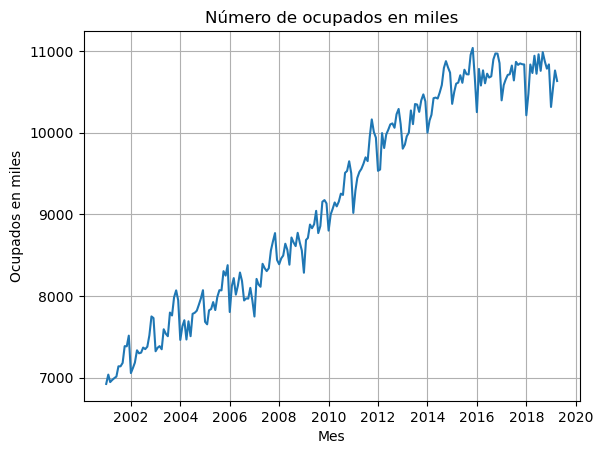

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Número de ocupados en miles")
plt.xlabel("Mes")
plt.ylabel("Ocupados en miles")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

C:\Users\Esteban Ordoñez\AppData\Local\Temp\ipykernel_8900\3843776200.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


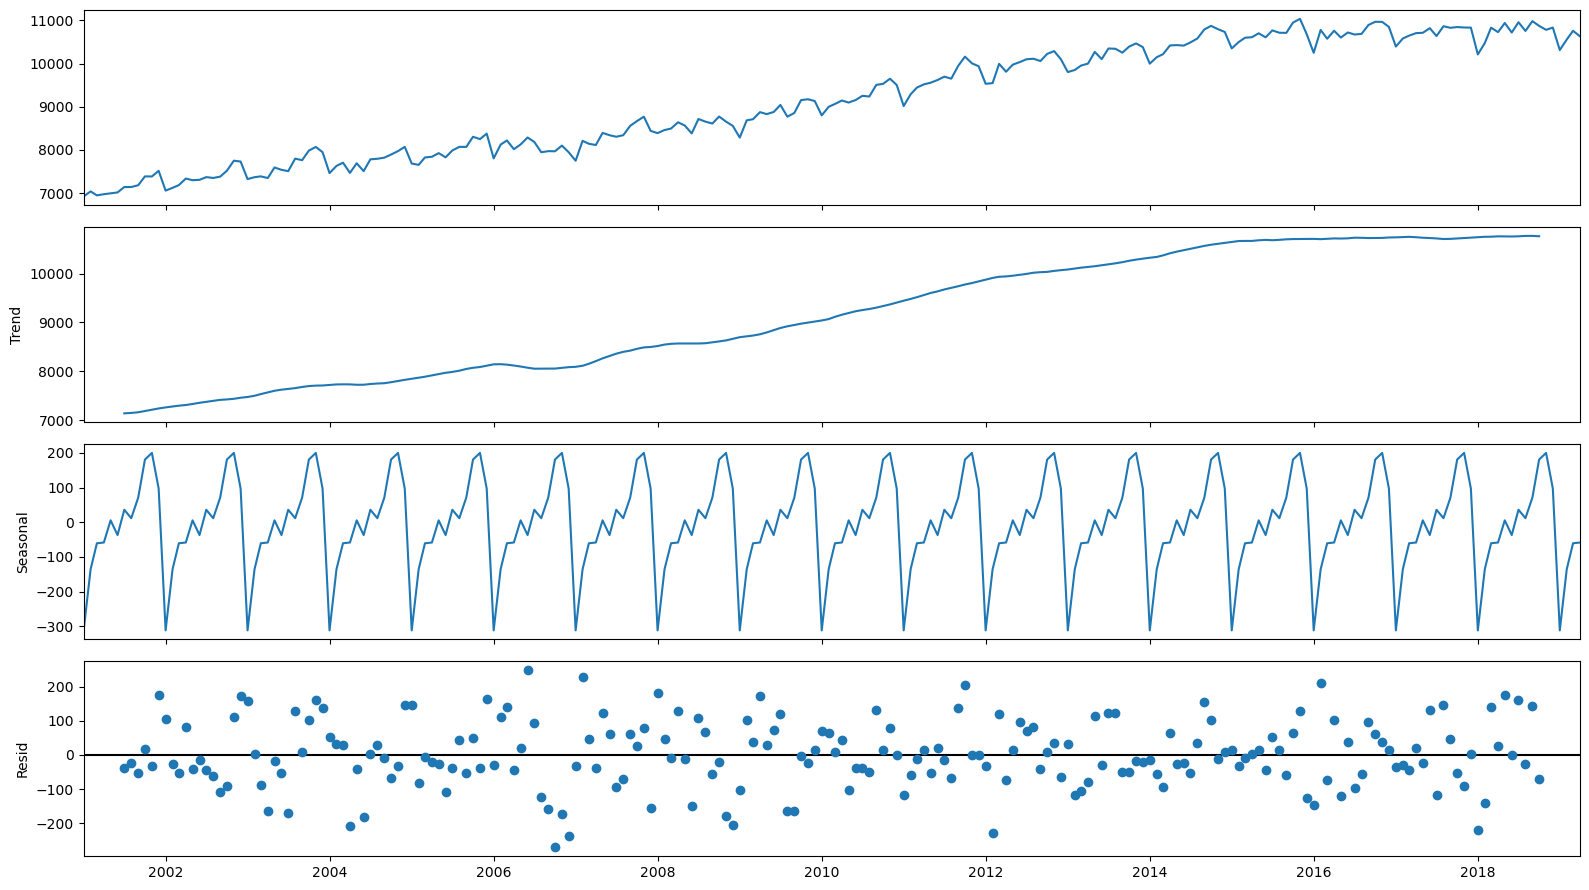

In [4]:
td_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

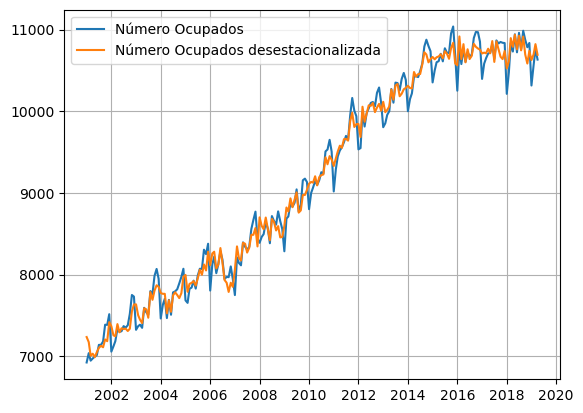

In [5]:
td_desestacionalizada = data["Ocupados"]-td_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Número Ocupados")
plt.plot(td_desestacionalizada,label="Número Ocupados desestacionalizada")
plt.legend()
plt.grid()
plt.show()


## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos 6 meses 

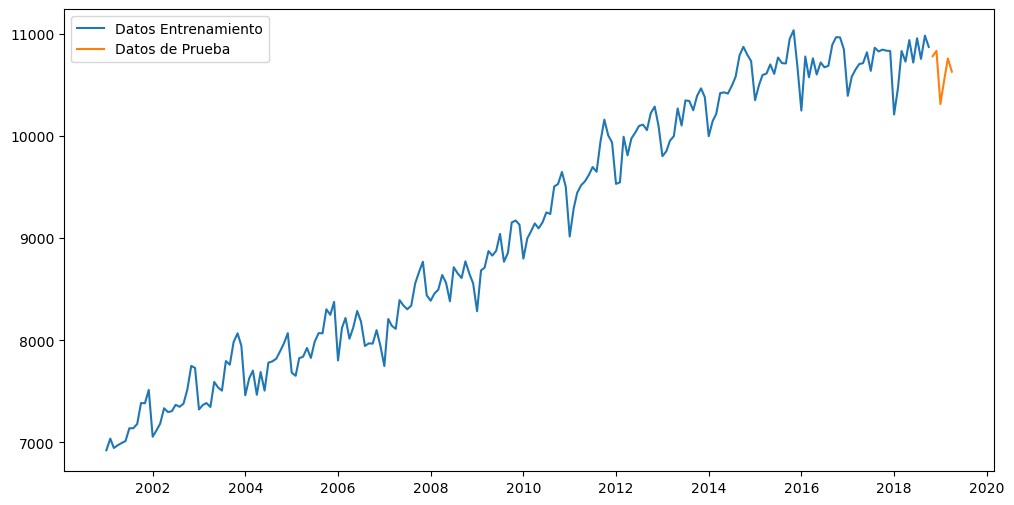

In [6]:
train_len = 214
train_ocu = data[["Ocupados"]][:train_len]
test_ocu = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_ocu,label="Datos Entrenamiento")
plt.plot(test_ocu,label="Datos de Prueba")
plt.legend()
plt.show()

In [7]:
train_ocu

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782


In [8]:
test_ocu

,Ocupados
mes,
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028


### **4.1 Promedio movil**

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

In [9]:
## Considerando el dato actual
ma_2= train_ocu.rolling(2,min_periods=2).mean()
ma_3= train_ocu.rolling(3,min_periods=2).mean()
ma_4= train_ocu.rolling(4,min_periods=2).mean()
ma_5= train_ocu.rolling(5,min_periods=2).mean()

In [10]:
## Sin considerar el dato actual
ma_2= train_ocu.shift().rolling(2,min_periods=2).mean()
ma_3= train_ocu.shift().rolling(3,min_periods=2).mean()
ma_4= train_ocu.shift().rolling(4,min_periods=2).mean()
ma_5= train_ocu.shift().rolling(5,min_periods=2).mean()


In [11]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:] 

In [12]:
ma_2_f= fore_ma(train_ocu,2,6)
ma_3_f= fore_ma(train_ocu,3,6)
ma_4_f= fore_ma(train_ocu,4,6)
ma_5_f= fore_ma(train_ocu,5,6)
ma_6_f= fore_ma(train_ocu,6,6)

In [13]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_ocu,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_ocu,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_ocu,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_ocu,ma_5_f ))
rmse_ma_6 = np.sqrt(mean_squared_error(test_ocu,ma_6_f ))

In [14]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5,rmse_ma_6)

319.1849777906289 298.3770292088787 305.34686253059 291.01606293356485 291.5713004314995


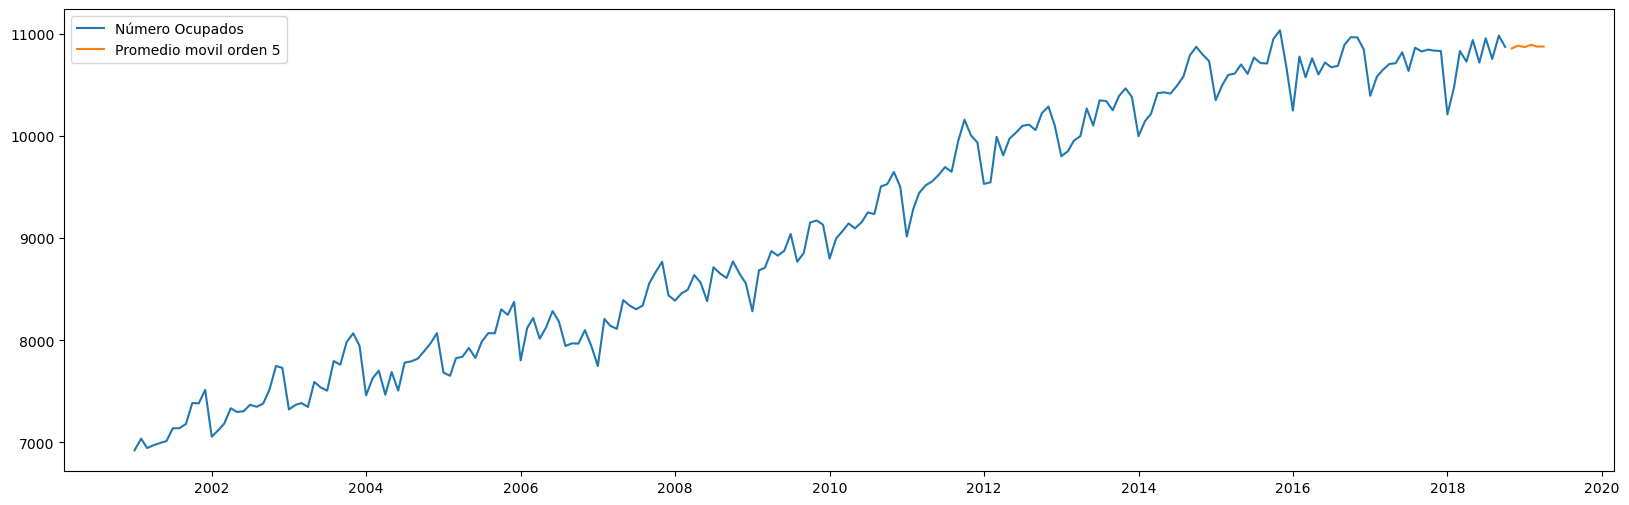

In [15]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_ocu,label="Número Ocupados")
plt.plot(ma_5_f,label="Promedio movil orden 5")
plt.legend()
plt.show()

### **4.2 Grid search - Suavizacion Exponencial Simple, Suavizacion Exponencial Lineal (Holt) y Suavizacion Exponencial Lineal de Winters (Holt-Winters)** 

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Error with parameters error=None, trend=add, seasonal=add: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=add, seasonal=mul: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=add, seasonal=None: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=mul, seasonal=add: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=mul, seasonal=mul: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=mul, seasonal=None: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=None, seasonal=add: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=None, seasonal=mul: 'NoneType' object is not subscriptable
Error with parameters error=None, trend=None, seasonal=None: 'NoneType' object is not subscriptable
Best Parameters: error=add, trend=None, seasonal=mul
Best RMSE: 93.49748800811417


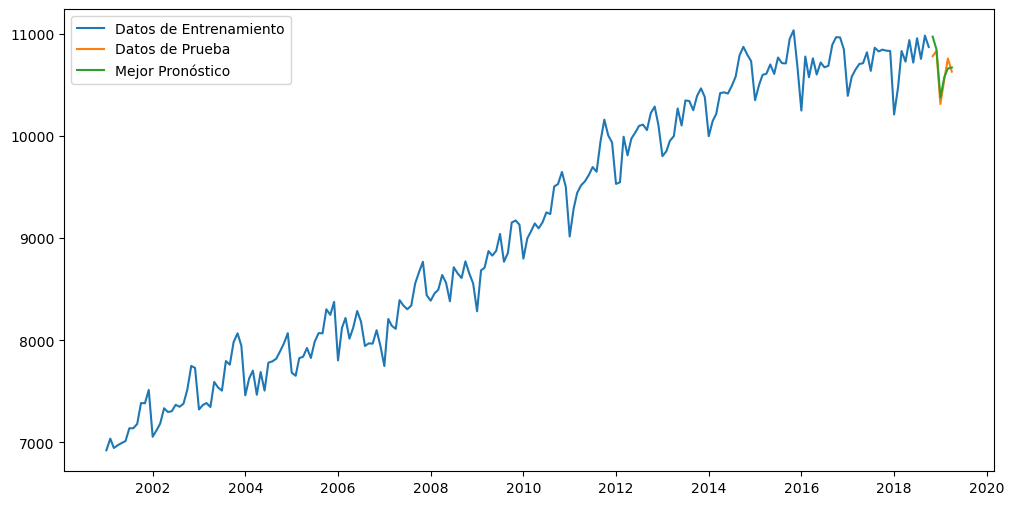

   Error Trend Seasonal        RMSE     Alpha      Beta     Gamma
0    add   add      add  178.557937  0.496696  0.000050  0.000050
1    add   add      mul  156.414705  0.513366  0.001316  0.000049
2    add   add     None  370.157961  0.571964  0.006149       NaN
3    add   mul      add  169.239323  0.388737  0.000039  0.337249
4    add   mul      mul  154.843264  0.513629  0.000051  0.000049
5    add   mul     None  381.545854  0.545042  0.000055       NaN
6    add  None      add  113.248334  0.591799       NaN  0.000041
7    add  None      mul   93.497488  0.595512       NaN  0.000040
8    add  None     None  300.429030  0.634303       NaN       NaN
9    mul   add      add  166.378361  0.348918  0.000035  0.326179
10   mul   add      mul  162.249840  0.550834  0.000331  0.000045
11   mul   add     None  371.544354  0.578280  0.005945       NaN
12   mul   mul      add  208.659143  0.306352  0.002579  0.425144
13   mul   mul      mul  160.647656  0.546514  0.000055  0.000045
14   mul  

In [16]:

# Definir las combinaciones de parámetros
params_grid = list(product(["add", "mul", None], repeat=3))

# Inicializar variables para guardar el mejor resultado
best_rmse = float('inf')
best_params = None
best_model = None

# Lista para guardar los resultados
results = []

# Loop para evaluar cada combinación de parámetros
for error, trend, seasonal in params_grid:
    try:
        # Entrenar el modelo
        ets_model = ETSModel(endog=train_ocu["Ocupados"], error=error, trend=trend, seasonal=seasonal)
        ets_result = ets_model.fit()
        
        # Realizar predicciones
        forecast_len = len(test_ocu)
        point_forecast = ets_result.forecast(forecast_len)
        
        # Calcular el RMSE
        rmse = np.sqrt(mean_squared_error(test_ocu["Ocupados"], point_forecast))
        
        # Extraer los parámetros del modelo, asignar np.nan si el parámetro no está definido
        alpha = ets_result.alpha 
        beta = ets_result.beta if trend is not None else np.nan
        gamma = ets_result.gamma if seasonal is not None else np.nan
        
        # Guardar los resultados
        results.append((error, trend, seasonal, rmse, alpha, beta, gamma))
        
        # Guardar el mejor modelo
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (error, trend, seasonal)
            best_model = ets_result
            
    except Exception as e:
        # Ignorar combinaciones no válidas
        print(f"Error with parameters error={error}, trend={trend}, seasonal={seasonal}: {e}")

# Mostrar los mejores parámetros y el RMSE
print(f"Best Parameters: error={best_params[0]}, trend={best_params[1]}, seasonal={best_params[2]}")
print(f"Best RMSE: {best_rmse}")

# Graficar el mejor modelo
fig = plt.figure(figsize=(12, 6))
plt.plot(train_ocu, label="Datos de Entrenamiento")
plt.plot(test_ocu, label="Datos de Prueba")
plt.plot(test_ocu.index, best_model.forecast(forecast_len), label="Mejor Pronóstico")
plt.legend()
plt.show()

# DataFrame con los resultados
results_df = pd.DataFrame(results, columns=['Error', 'Trend', 'Seasonal', 'RMSE', 'Alpha', 'Beta', 'Gamma'])
print(results_df)



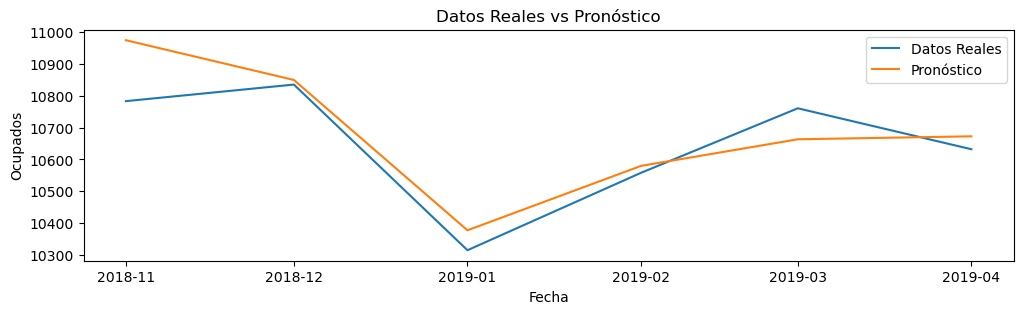

In [17]:
# Graficar el mejor modelo - Parte real vs. pronosticada
fig = plt.figure(figsize=(12, 3))
plt.plot(test_ocu.index, test_ocu["Ocupados"], label="Datos Reales")
plt.plot(test_ocu.index, best_model.forecast(forecast_len), label="Pronóstico")
plt.xlabel('Fecha')
plt.ylabel('Ocupados')
plt.title('Datos Reales vs Pronóstico')
plt.legend()
plt.show()

El mejor modelo es aquel que tiene error add y seasonal mul, con un rmse de 93.497 y valore de alpha 0.595512 y  Gamma 0.000040:

In [18]:
# Build best model
ets_model = ETSModel(endog=train_ocu["Ocupados"],error="add",seasonal="mul" )
ets_result = ets_model.fit()

# forecast
point_forecast=ets_result.forecast(6)

# Confidence intervals
ci = ets_result.get_prediction(start = point_forecast.index[0], end = point_forecast.index[-1])
conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10974.856215  10726.776665  11207.234225
2018-12-01    10849.851789  10572.409731  11115.826244
2019-01-01    10377.100885  10077.234603  10655.569641
2019-02-01    10579.686166  10230.905406  10912.574433
2019-03-01    10663.322164  10293.199941  11032.332736
2019-04-01    10672.645967  10259.033380  11043.945378


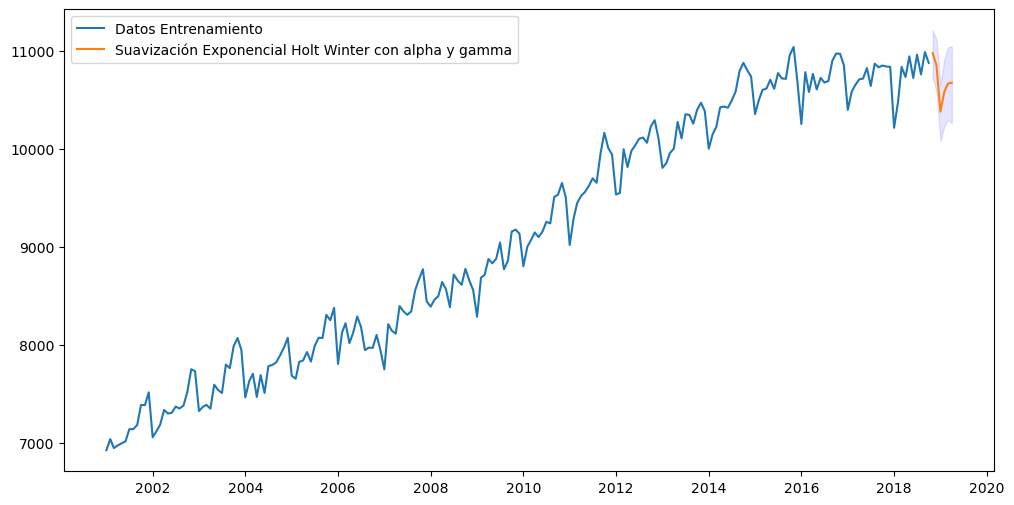

In [19]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_ocu,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Holt Winter con alpha y gamma")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [20]:
rmse = np.sqrt(mean_squared_error(test_ocu,point_forecast))
print(rmse)

93.49748800811417


In [21]:
print(ets_result.alpha,ets_result.gamma)

0.5955124615321116 4.044875384678884e-05


In [22]:
print(ets_result.alpha,ets_result.gamma)

0.5955124615321116 4.044875384678884e-05


### **5. Se ajusta el modelo con el train y se observan los hiperparametros obtenidos en la optimización**

In [23]:
ets_model = ETSModel(endog=train_ocu["Ocupados"],error="add",seasonal="mul" )
ets_result = ets_model.fit()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [24]:
## Se obtienen los hiperparametros

print(ets_result.alpha)
print(ets_result.gamma)
print(ets_result.param_names)

0.5955124615321116
4.044875384678884e-05
['smoothing_level', 'smoothing_seasonal', 'initial_level', 'initial_seasonal.0', 'initial_seasonal.1', 'initial_seasonal.2', 'initial_seasonal.3', 'initial_seasonal.4', 'initial_seasonal.5', 'initial_seasonal.6', 'initial_seasonal.7', 'initial_seasonal.8', 'initial_seasonal.9', 'initial_seasonal.10', 'initial_seasonal.11']


### Hacemos la prediccion

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                Fecha    Predicción
2019-05-01 2019-04-30  10734.559922
2019-06-01 2019-05-31  10690.134412
2019-07-01 2019-06-30  10777.704615
2019-08-01 2019-07-31  10748.327645
2019-09-01 2019-08-31  10823.108421
2019-10-01 2019-09-30  10946.551966


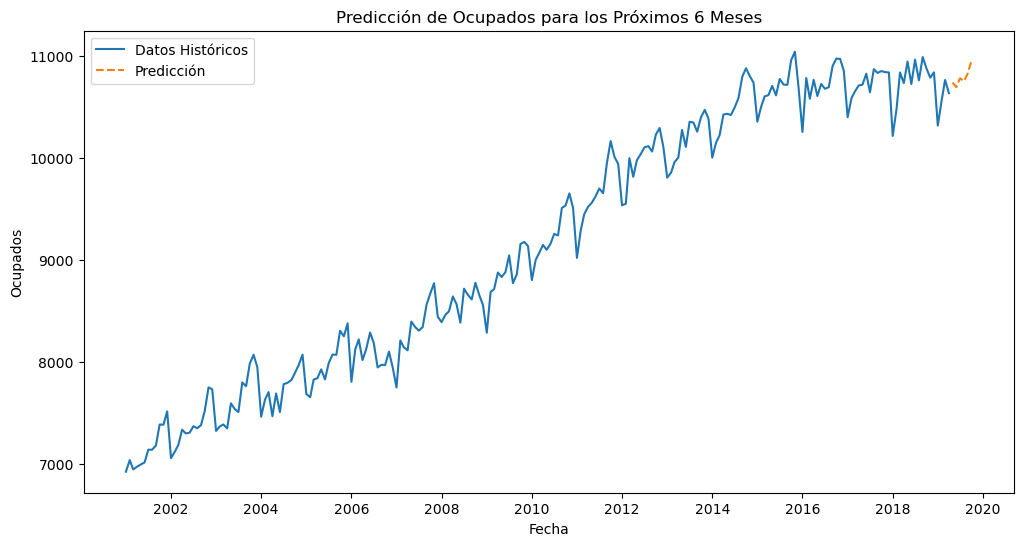

In [25]:

# Ajustar el modelo con todos los datos disponibles
final_model = ETSModel(endog=data["Ocupados"], error="add", seasonal="mul")
final_model_fit = final_model.fit_constrained({'smoothing_level': 0.5955124615321116, 'smoothing_seasonal':4.044875384678884e-05})

# Realizar la predicción para los próximos 6 meses
forecast_horizon = 6
forecast = final_model_fit.forecast(steps=forecast_horizon)

# Crear un rango de fechas para la predicción
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='M')

# Crear un DataFrame para las predicciones
forecast_df = pd.DataFrame({'Fecha': forecast_index, 'Predicción': forecast})

# Mostrar la tabla de predicciones
print(forecast_df)

# Plotear los datos históricos y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Ocupados"], label='Datos Históricos')
plt.plot(forecast_index, forecast, label='Predicción', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Ocupados')
plt.title('Predicción de Ocupados para los Próximos 6 Meses')
plt.legend()
plt.show()

